# Import required packages

In [1]:
#Import required packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from pyecharts import Bar
import plotly.express as px
from datetime import datetime
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
import warnings
warnings.filterwarnings('ignore')
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
from dotenv import load_dotenv

In [2]:
end_date = '2022-09-30'
year = ['2021-2022', '2022-2023']
period = 'FY22Q2'

# Download databases

In [3]:
#Connecting to Commcare
load_dotenv('id_cc.env')
email = os.getenv('COMCARE_EMAIL')
password = os.getenv('COMCARE_PASSWORD')

#Defining the driver
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.implicitly_wait(1000)

#-------------------------------------------------------------------------------------------------------------------------------------------

#Positive_kids_Information
def positive_kids():
    driver.get(
    "https://www.commcarehq.org/a/caris-test/data/export/custom/new/case/download/67352311fba5d3a5e285283aa4951676/"
    )
    driver.find_element(By.XPATH,'//*[@id="id_auth-username"]').send_keys(email)
    driver.find_element(By.XPATH,'//*[@id="id_auth-password"]').send_keys(password)
    driver.find_element(By.CSS_SELECTOR,'button[type=submit]').click()
    
positive_kids()

#Download positive database
driver.find_element(By.XPATH,"//*[@id='download-export-form']/form/div[2]/div/div[2]/div[1]/button/span[1]").click()
driver.find_element(By.XPATH,"//*[@id='download-progress']/div/div/div[2]/div[1]/form/a/span[1]").click()   
#-----------------------------------------------------------------------------------------------------------------------------------------

#OEV_kids_information

def oev_kids():
    driver.get(
    "https://www.commcarehq.org/a/caris-test/data/export/custom/new/case/download/690dc95932c1877d83a175978e1fa797/"
        )

oev_kids()
#Download oev database
driver.find_element(By.XPATH,'//*[@id="download-export-form"]/form/div[2]/div/div[2]/div[1]/button/span[1]').click()
driver.find_element(By.XPATH,'//*[@id="download-progress"]/div/div/div[2]/div[1]/form/a/span[1]').click()

#------------------------------------------------------------------------------------------------------------------------------------------

#Siblings
def siblings():
    driver.get(
    "https://www.commcarehq.org/a/caris-test/data/export/custom/new/case/download/690dc95932c1877d83a175978efa7448/"
    )

siblings()

#Download siblings
driver.find_element(By.XPATH,'//*[@id="download-export-form"]/form/div[2]/div/div[2]/div[1]/button/span[1]').click()
driver.find_element(By.XPATH,'//*[@id="download-progress"]/div/div/div[2]/div[1]/form/a/span[1]').click()


True

# Importing all databases

In [4]:
#Importing databases

positive = pd.read_excel(f"~/Downloads/schooling Enfant positif {str(datetime.today().strftime('%Y-%m-%d'))}.xlsx", parse_dates = True)
oev = pd.read_excel(f"~/Downloads/schooling oev {str(datetime.today().strftime('%Y-%m-%d'))}.xlsx", parse_dates = True)
siblings = pd.read_excel(f"~/Downloads/schooling sibling  {str(datetime.today().strftime('%Y-%m-%d'))}.xlsx", parse_dates = True)


# Data wrangling

In [5]:
#Rename some columns

positive.rename(columns = {'mention_reussie': 'eskew_pase'}, inplace = True)

oev.rename(columns = {'parent_patient_code':'patient_code',
                     'school_commune_1': 'school_commune',
                     'is_infant_success_school_year': 'eskew_pase'}, inplace = True)

siblings.rename(columns = {'parent_patient_code':'patient_code',
                           'is_infant_success_school_year': 'eskew_pase'}, inplace = True)

#---------------------------------------------------------------------------------------------------------------------------------------------------
#Add a categorical column
positive['type'] = 'positif'
oev['type'] = 'oev'
siblings['type'] = 'fratrie'

#filtering
c_positive = positive[positive['schooling_year'].isin(year)]
c_positive = c_positive.drop_duplicates('patient_code').reset_index(drop = True)
c_oev = oev[oev['schooling_year'].isin(year)]
c_siblings = siblings[siblings['schooling_year'].isin(year)]

#---------------------------------------------------------------------------------------------------------------------------------------------------
#Subsets from main databases

# Interest columns
col = ['caseid', 'fullname', 'infant_dob', 'gender', 'infant_commune', 'type', 'office', 'patient_code', 'closed', 'school_commune', 
       'schooling_year', 'eskew_peye', 'eskew_pase']

c_positive = c_positive[col]
c_oev = c_oev[col]
c_siblings = c_siblings[col]

schooling_data_1 = pd.concat([c_positive, c_oev])
schooling_survey = schooling_data_1.append(c_siblings).reset_index(drop=True)

# #---------------------------------------------------------------------------------------------------------------------------------------------------
#Creating age column
c_positive['infant_dob'] = pd.to_datetime(c_positive['infant_dob'], errors = 'coerce')
c_oev['infant_dob'] = pd.to_datetime(c_oev['infant_dob'], errors = 'coerce')
c_siblings['infant_dob'] = pd.to_datetime(c_siblings['infant_dob'], errors = 'coerce')

#FUnction 1
def get_age(date):
    return relativedelta(parse(end_date), date).years

#Function 2
def age_range(age):
    if age < 1:
        return '< 1'
    elif age in range(1, 5):
        return '1 - 4'
    elif age in range(5, 10):
        return '5 - 9'
    elif age in range(10, 15):
        return '10 - 14'
    elif age in range(15, 18):
        return '15 - 17'
    else:
        return '18+'


schooling_survey['infant_dob'] = pd.to_datetime(schooling_survey['infant_dob'], errors = 'coerce')
schooling_survey['age'] = schooling_survey['infant_dob'].map(get_age)
schooling_survey['age_range'] = schooling_survey['age'].map(age_range)

#----------------------------------------------------------------------------------------------------------------------------------------------------
#Replace some values in 'eskew_pase' column
schooling_survey['eskew_pase'].replace(['wi_fra', 'non_fra'], ['wi', 'non'], inplace = True)
schooling_survey['gender'].replace(['1', '2'], ['Male', 'Female'], inplace = True)
#---------------------------------------------------------------------------------------------------------------------------------------------------


schooling_survey.shape[0]
schooling_survey['office'].fillna('CAP', inplace = True)
schooling_survey.head(2)

4155

,caseid,fullname,infant_dob,gender,infant_commune,type,office,patient_code,closed,school_commune,schooling_year,eskew_peye,eskew_pase,age,age_range
0,bce27881-c1cd-4367-ae84-b45479a99dac,Seska Bien-Aime,2019-01-28,Female,Mombin-Crochu,positif,CAP,CAP/CSBL/ST00082,False,---,2021-2022,wi,---,3,1 - 4
1,c85955b8-efac-40fa-b666-ece8cbf2eb51,Daika Bien-Aime,2009-05-07,Female,Mombin-Crochu,positif,CAP,CAP/CSBL/ST00083,False,---,2021-2022,wi,---,13,10 - 14


# Surveyed kids

In [6]:
#FY22 Database
positive_surveyed = schooling_survey[schooling_survey['type'] == 'positif']
oev_surveyed = schooling_survey[schooling_survey['type'] == 'oev']
siblings_surveyed = schooling_survey[schooling_survey['type'] == 'fratrie']

df_surveyed = pd.DataFrame(data = [positive_surveyed.shape[0], oev_surveyed.shape[0], 
                                   siblings_surveyed.shape[0]], index = ['positive_surveyed', 'oev_surveyed', 'siblings_surveyed'], 
                 columns = ['Total'])
df_surveyed.reset_index(inplace = True)
df_surveyed

,index,Total
0,positive_surveyed,1097
1,oev_surveyed,2171
2,siblings_surveyed,887


In [7]:
df_surveyed['Total'].sum()

4155

# Barplot for surveyed kids

<AxesSubplot:xlabel='index', ylabel='Total'>

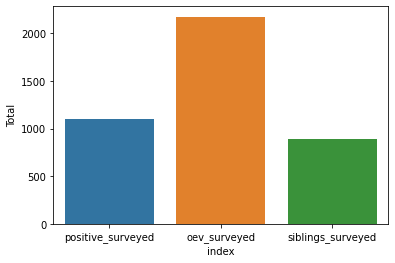

In [8]:
survey = sns.barplot(x='index', y='Total', data = df_surveyed)
survey

In [9]:
# plt.barh(df_surveyed['index'], df_surveyed['Total'])

# Schooling Beneficiaries

In [10]:
pos_benef = positive_surveyed[positive_surveyed['eskew_peye'] == 'wi']
oev_benef = oev_surveyed[oev_surveyed['eskew_peye'] == 'wi']
sib_benef = siblings_surveyed[siblings_surveyed['eskew_peye'] == 'wi']

df_benef = pd.DataFrame(data = [pos_benef.shape[0], oev_benef.shape[0], sib_benef.shape[0]], 
                        index = ['positive_benef', 'oev_benef', 'siblings_benef'], 
                 columns = ['Total'])
df_benef.reset_index(inplace = True)
df_benef

,index,Total
0,positive_benef,1031
1,oev_benef,1975
2,siblings_benef,772


In [11]:
df_benef['Total'].sum()

3778

# Bar plot for payment

<AxesSubplot:xlabel='index', ylabel='Total'>

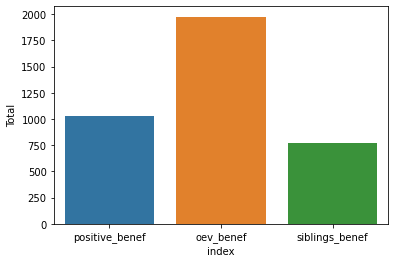

In [12]:
payment = sns.barplot(x='index', y='Total', data = df_benef)
payment

In [13]:
schooling_benef = schooling_survey[schooling_survey['eskew_peye'] == 'wi']
PT = schooling_benef.pivot_table(index = 'age_range', columns = 'type',values = 'caseid', aggfunc = len)

PT = PT.reindex(['< 1', '1 - 4', '5 - 9', '10 - 14', '15 - 17', '18+'])
PT.rename(columns = {'caseid': "Nombre de paiement enregistré"}, inplace = True)
PT = PT.append(PT.sum(numeric_only=True).rename('Total'))
# PT = PT.reindex(columns = columns)
PT

type,fratrie,oev,positif
age_range,,,
< 1,NaN,NaN,4.0
1 - 4,NaN,NaN,8.0
5 - 9,209.0,607.0,160.0
10 - 14,362.0,1033.0,414.0
15 - 17,151.0,275.0,222.0
18+,50.0,60.0,223.0
Total,772.0,1975.0,1031.0


In [14]:
Datim = schooling_benef.pivot_table(index = 'infant_commune', values = 'caseid', columns = ['gender', 'age_range'], aggfunc = len,
                                   margins = True, margins_name = 'Total')

columns = [('Female', '< 1'),
 ('Female', '1 - 4'),
 ('Female', '5 - 9'),
 ('Female', '10 - 14'),
 ('Female', '15 - 17'),
 ('Female', '18+'),
 ('Male', '< 1'),
 ('Male', '1 - 4'),
 ('Male', '5 - 9'),
 ('Male', '10 - 14'),
 ('Male', '15 - 17'),
 ('Male', '18+')]

Datim = Datim.reindex(columns = columns)
Datim.fillna(0, inplace = True)
# Datim.columns = ['_'.join(col) for col in Datim.columns.values]
# Datim.rename(columns = {'':'Co'})
Datim

gender          Female                                     Male               \
age_range          < 1 1 - 4  5 - 9 10 - 14 15 - 17    18+  < 1 1 - 4  5 - 9   
infant_commune                                                                 
Abricots           0.0   0.0    2.0     0.0     0.0    0.0  0.0   0.0    4.0   
Acul-du-Nord       0.0   0.0    0.0     0.0     0.0    0.0  0.0   0.0    1.0   
Anse-Rouge         0.0   0.0    1.0     0.0     0.0    0.0  0.0   0.0    0.0   
Anse-d'Hainault    0.0   0.0    0.0     1.0     0.0    0.0  0.0   0.0    0.0   
Anse-à-Foleur      0.0   0.0    1.0     0.0     0.0    0.0  0.0   0.0    1.0   
...                ...   ...    ...     ...     ...    ...  ...   ...    ...   
Torbeck            0.0   0.0    0.0     0.0     0.0    0.0  0.0   0.0    1.0   
Trou-du-Nord       0.0   0.0    7.0    13.0     5.0    0.0  0.0   0.0    5.0   
Verrettes          0.0   0.0    0.0     1.0     1.0    1.0  0.0   0.0    0.0   
Île-à-Vache        0.0   0.0    1.0     0.0     0.0    0.0  0.0   0.0    0.0   
Total              2.0   4.0  440.0   780.0   275.0  145.0  1.0   4.0  325.0   

gender                                  
age_range       10 - 14 15 - 17    18+  
infant_commune                          
Abricots            0.0     0.0    0.0  
Acul-du-Nord        0.0     2.0    0.0  
Anse-Rouge          0.0     0.0    0.0  
Anse-d'Hainault     1.0     0.0    0.0  
Anse-à-Foleur       0.0     0.0    0.0  
...                 ...     ...    ...  
Torbeck             0.0     0.0    0.0  
Trou-du-Nord        8.0     3.0    2.0  
Verrettes           3.0     1.0    1.0  
Île-à-Vache         0.0     0.0    0.0  
Total             662.0   220.0  137.0  

[106 rows x 12 columns]

In [15]:
# Beneficiaries by office

office_surv = schooling_survey.pivot_table(index = 'office', values = 'caseid', aggfunc = len, margins = True, margins_name = 'Total')
office_surv.rename(columns = {'caseid': 'Questionnaire'}, inplace = True)

#-------------------------------------------------------------------------------------------------------------------
office_pay = schooling_benef.pivot_table(index = 'office', values = 'caseid', aggfunc = len, margins = True, margins_name = 'Total')
office_pay.rename(columns = {'caseid': 'Paiement'}, inplace = True)

office_data = office_surv.merge(office_pay, on = 'office', how = 'left')
# office_data.append(office_data.sum(numeric_only=True).rename('Total'))
office_data.reset_index(inplace = True)
# office_data['Pourcentage'] = round((office_data['Paiement']/office_data['Questionnaire'])*100, 0).astype(str) + '%'
# office_data

# office_data.append(office_data.sum(numeric_only=True), ignore_index=True)
# office_data['office'].replace('NaN', 'Total', inplace = True)

# office_data.reset_index(inplace = True)
office_data

,office,Questionnaire,Paiement
0,BOM,33,26
1,CAP,680,640
2,CAY,167,127
3,GON,242,234
4,JER,109,105
5,PAP,2746,2470
6,PDP,178,176
7,Total,4155,3778


In [16]:
data_desag = schooling_benef.pivot_table(index = 'office', columns = 'type', values = 'caseid', aggfunc = len, margins = True, margins_name = 'Total')
# data_desag.reset_index(inplace = True)
data_desag.fillna(0, inplace = True)
data_desag

type,fratrie,oev,positif,Total
office,,,,
BOM,1,18,7,26
CAP,137,289,214,640
CAY,12,68,47,127
GON,35,90,109,234
JER,22,64,19,105
PAP,529,1384,557,2470
PDP,36,62,78,176
Total,772,1975,1031,3778


In [17]:
data_all = schooling_survey.pivot_table(index = 'office', columns = 'type', values = 'caseid', aggfunc = len, margins = True, margins_name = 'Total')
# data_all.reset_index(inplace = True)
data_all.fillna(0, inplace = True)
data_all

type,fratrie,oev,positif,Total
office,,,,
BOM,4,22,7,33
CAP,152,304,224,680
CAY,15,79,73,167
GON,36,96,110,242
JER,22,66,21,109
PAP,621,1541,584,2746
PDP,37,63,78,178
Total,887,2171,1097,4155


In [18]:
schooling_benef_17 = schooling_benef[schooling_benef['age_range'] != '18+']
schooling_benef_17.shape[0]

3445

# Exporting output

In [19]:
#############

schooling_survey.to_excel(f"Schooling_data_consolidated_{period}_{str(datetime.today().strftime('%Y-%m-%d'))}.xlsx", index = False)
Datim.to_excel('Datim_FY22Q2.xlsx')

In [ ]:
import openpyxl

with pd.ExcelWriter(f"Data-Schooling_Commcare_{period}_{str(datetime.today().strftime('%Y-%m-%d'))}.xlsx", 
                    engine = 'openpyxl') as writer:
    office_data.to_excel(writer, sheet_name = 'Data_commcare', index = False)
    data_all.to_excel(writer, sheet_name = 'Survey_data')
    data_desag.to_excel(writer, sheet_name = 'Payment_data')

In [ ]:
driver.quit()

---